In [1]:
from sklearn.cluster import KMeans # KMedoids clust = KMedoids(n_clusters=20, random_state=0, metric='euclidean').fit(d1)

import numpy as np
import joblib
import os, yaml, sys
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from dim_redu_anns.utils import get_relevant_output_layers
from pref_viewing.utils import plot_imgs, get_extreme_k
from pref_viewing.psychometric_exp import get_dimension_progression
from sklearn.cluster import KMeans
from torchvision.models.feature_extraction import (
    create_feature_extractor,
    get_graph_node_names,
)
from torchvision import models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from alignment.utils import get_usual_transform
import math

In [2]:
def get_k_imgs(dim_rid1, dataset, k, dim):
    sorted_indices = np.argsort(dim_rid1[:, dim])  # ascending order
    
    topk_indices = sorted_indices[-k:][::-1]  # descending: highest values
    bottomk_indices = sorted_indices[:k] 
    topk_imgs = [dataset[i][0].permute(1,2,0) for i in topk_indices]
    bottomk_imgs = [dataset[i][0].permute(1,2,0) for i in bottomk_indices]
    return topk_imgs, bottomk_imgs

In [3]:
transform = transforms.Compose(
    [      
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
) #       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
dataset = datasets.ImageFolder(f"{paths["data_path"]}/imagenet", transform=transform)

In [4]:
model_name1 = "resnet50"
model_name2 = "vit_b_16"
mod1_layers = get_relevant_output_layers(model_name1)
mod2_layers = get_relevant_output_layers(model_name2)

In [5]:

target_layer1 = mod1_layers[10]
target_layer2 = mod2_layers[3]

pooling = "maxpool"
n_components_cca = 50
feats_path1 = f"{paths["results_path"]}/imagenet_val_{model_name1}_{target_layer1}_{pooling}_features.pkl"
feats1 = joblib.load(feats_path1)
PCs1_path = f"{paths["results_path"]}/imagenet_val_{model_name1}_{target_layer1}_{pooling}_pca_model_1000_PCs.pkl"
PCs1 = joblib.load(PCs1_path)
feats_path2 = f"{paths["results_path"]}/imagenet_val_{model_name2}_{target_layer2}_{pooling}_features.pkl"
feats2 = joblib.load(feats_path2)
PCs2_path = f"{paths["results_path"]}/imagenet_val_{model_name2}_{target_layer2}_{pooling}_pca_model_1000_PCs.pkl"
PCs2 = joblib.load(PCs2_path)
cca_path = f"{paths["results_path"]}/cca_{model_name1}_vs_{model_name2}_{pooling}/cca_{model_name1}_vs_{model_name2}_{n_components_cca}_components_pca_{target_layer1}_vs_{target_layer2}.pkl"

weights_dict = joblib.load(cca_path)

In [6]:
dim_rid1 = feats1@PCs1.components_.T
if feats1.shape[1]>1000:
    d1 = dim_rid1 @ weights_dict["W1"]
else:
    d1 = feats1 @ weights_dict["W1"]

In [7]:
dim_rid2 = feats2@PCs2.components_.T
if feats2.shape[1]>1000:
    d2 = dim_rid2 @ weights_dict["W2"]
else:
    d2 = feats2 @ weights_dict["W2"]

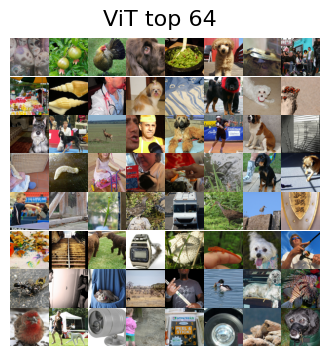

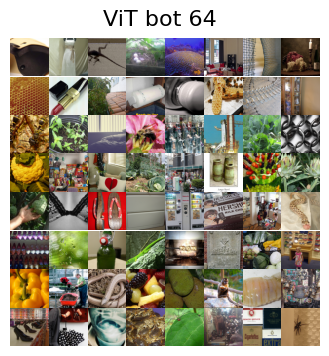

In [8]:
k = 64
dim = 0 
mod2_topk_imgs, mod2_bottomk_imgs = get_k_imgs(dim_rid2, dataset, k, dim)
mod2_topk_imgs_cca, mod2_bottomk_imgs_cca = get_k_imgs(d2, dataset, k, dim)
mod2_top = plot_imgs(mod2_topk_imgs, f"ViT top {k}", 4)
mod2_bot = plot_imgs(mod2_bottomk_imgs, f"ViT bot {k}", 4)

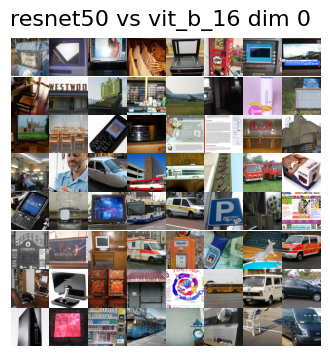

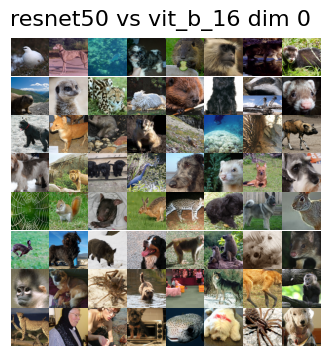

In [13]:
mod2_cca_top_plot = plot_imgs(mod2_topk_imgs_cca, f"{model_name1} vs {model_name2} dim {dim}", 4)
mod2_cca_bot_plot = plot_imgs(mod2_bottomk_imgs_cca, f"{model_name1} vs {model_name2} dim {dim}", 4)



max : 9.200279870735358 
min : 1.0630932960029789
levels [9.20027987 8.18313155 7.16598323 6.14883491 5.13168658 4.11453826
 3.09738994 2.08024162 1.0630933 ]
only 3 images for the top extreme, getting top 10
only 2 images for the bottom extreme, getting bottom 10
10 10
4


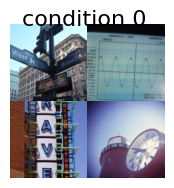

4


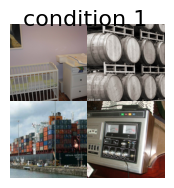

4


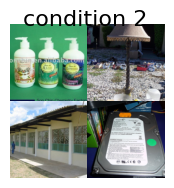

4


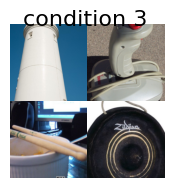

4


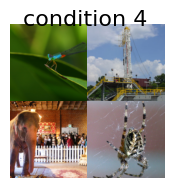

4


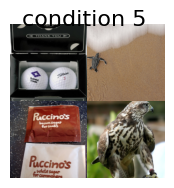

4


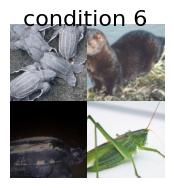

4


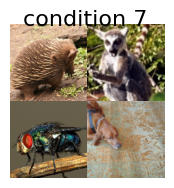

4


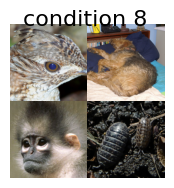

In [11]:
num_conditions = 9
img_lvls = get_dimension_progression(num_conditions, d1, .15, (1,0))


for i in range(num_conditions):
    curr_idx = img_lvls[i]
    rand2 =  np.random.choice(len(curr_idx), size=min(curr_idx.shape[0],4), replace=False)
    imgs = [dataset[int(idx)][0].permute(1, 2, 0) for idx in curr_idx[rand2]]
    print(len(imgs))
    #plot_imgs(dataset[curr_idx[:2]][0].permute(1,2,0))
    plot_imgs(imgs, f"condition {i}")